In [1]:
#pip install yfinance

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [3]:
import seaborn as sns

sns.set_style("ticks")

In [4]:
import yfinance as yf

In [5]:
def arithmetic_return(price):
    pct = (price / price.shift(1))[1:]
    return pct - 1

def log_return(price):
    pct = (price / price.shift(1))[1:]
    return np.log(pct)

def cal_return(price, method):
    if method == 'Arithmetic':
        return arithmetic_return(price)
    elif method == 'Log':
        return log_return(price)

In [6]:
prices = pd.read_csv("DailyPrices.csv", parse_dates=[0], index_col=0)

returns = cal_return(prices["INTC"], method='Arithmetic')
returns -= returns.mean()

In [7]:
def VaR(simulations: 'array_like', mean='numeric', alpha: float=0.05):
    return mean - np.quantile(simulations, q=alpha)

In [8]:
var_hist = VaR(returns, 0)
print(var_hist)

0.020725168575353364


In [9]:
nsample = 10000
mu = 0
sigma = np.std(returns)
sim_rets_norm = np.random.normal(mu, sigma, nsample)

var_norm = VaR(sim_rets_norm, 0)
print(var_norm)

0.03404220302088202


In [10]:
# Exponentially Weighted Covariance
def exponential_weights(lambda_, nlags):
    weights = np.array([(1-lambda_) * (lambda_**(lag-1)) for lag in range(1,nlags+1)])
    weights /= weights.sum() # normalized weights
    return weights

def cal_ewcov(data, lambda_):
    """
    Calculate the exponentially weighted covariance of a dataset matrix.
    Equation:
    
        \sigma_t^2 = (1 − \lambda) \sum_{i=1}^{\infty}{\lambda^{i-1} (x_{t-i} - \bar{x})^2}
    
    params:
        - data: The dataset has n observations(ordered from the most recent to the least recent ) 
                on m varaibles. Can be denoted as [[x1_t-1, x1_t-2, ...., x1_t-n],
                                                    ...,
                                                   [xm_t-1, xm_t-2, ...., xm_t-n]].
                The dataset should be an instance of np.matrix (but not np.array). 
        
        - lambda_: to put how much weight on t-1's forecast variance
    """
    
    dev = data - data.mean(axis=1) # deviation
    weights = exponential_weights(lambda_, data.shape[1])
    
    # apply the weights to the deviation
    cov = dev @ np.diag(weights) @ dev.T
    return cov

In [11]:
nsample = 10000
ew_cov = cal_ewcov(np.matrix(returns), 0.94)[0, 0]
sim_rets_ewnorm = np.random.normal(0, np.sqrt(ew_cov), nsample)

var_ewnorm = VaR(sim_rets_ewnorm, 0)
print(var_ewnorm)

0.05038583471142931


In [12]:
df, loc, scale = stats.t.fit(returns)
sim_rets_t = stats.t(df=df, loc = loc, scale=scale).rvs(nsample)

var_t = VaR(sim_rets_t, 0)
print(var_t)

0.027005334781338024


In [13]:
print(f'VaR - Historical = {var_hist*100:.2f}%')
print(f'VaR - Normal = {var_norm*100:.2f}%')
print(f'VaR - EW Normal = {var_ewnorm*100:.2f}%')
print(f'VaR - T = {var_t*100:.2f}%')

VaR - Historical = 2.07%
VaR - Normal = 3.40%
VaR - EW Normal = 5.04%
VaR - T = 2.70%


/Users/hongrendemac/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/hongrendemac/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/hongrendemac/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a

Text(0.5, 1.0, 'Comparison with Future Data')

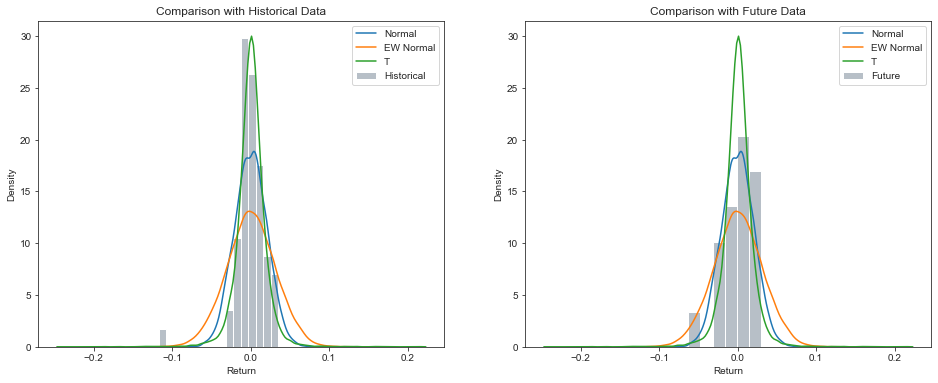

In [14]:
fig, axes = plt.subplots(1, 2,  figsize=(16,6))

# comparison with historical data
ax = axes[0]
sns.histplot(returns, stat='density', ax=ax, label='Historical', color='slategrey', alpha=0.5)
sns.distplot(sim_rets_norm, ax=ax, hist=False, label='Normal')
sns.distplot(sim_rets_ewnorm, ax=ax, hist=False, label='EW Normal')
sns.distplot(sim_rets_t, ax=ax, hist=False, label='T')
ax.legend()
ax.set_xlabel("Return")
ax.set_title("Comparison with Historical Data")


# comparison with future data
# load intel price data from Jan 15 to Jan 31 
future_prices = yf.Ticker("INTC").history(start="2022-01-14", period="max")
future_returns = cal_return(future_prices.Close, method = 'Arithmetic')
future_returns -= np.mean(future_returns)

ax = axes[1]
sns.histplot(future_returns, stat='density', ax=ax, label='Future', color='slategrey', alpha=0.5)
sns.distplot(sim_rets_norm, ax=ax, hist=False, label='Normal')
sns.distplot(sim_rets_ewnorm, ax=ax, hist=False, label='EW Normal')
sns.distplot(sim_rets_t, ax=ax, hist=False, label='T')
ax.legend()
ax.set_xlabel("Return")
ax.set_title("Comparison with Future Data")